In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import matthews_corrcoef
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.optim as optim

2024-12-17 14:43:22.977710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 14:43:22.994582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 14:43:22.999796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 14:43:23.012361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 14:43:23.922504: W tensorflow/compiler/tf2

In [2]:
df = pd.read_excel('/home/basilmusyaffa19/Skripsi Basil/Dataset/FIX/clean_SMS_22112024.xlsx', engine='openpyxl')
df

,teks,label
0,promo beli paket flash mulai aplikasi my telko...,1
1,gb hari rp ribu spesial buat kamu pilih aktif ...,1
2,plg hormat sisa kuota flash download aplikasi ...,1
3,mohon hormat sisa kuota flash download aplikas...,1
4,hari rp ribu khusus buat kamu pilih aktif seka...,1
...,...,...
1138,yooo sama sama aku umum kelompok kelas,0
1139,pernah tulis cadar belum pikir warna jeans,0
1140,bu mau kirim,0
1141,berangkat pagi mau tunai transfer,0


In [3]:
print("Jumlah data sebelum:", len(df))

# Menghapus data kosong
df = df.replace('', np.nan).dropna()
# Hapus NaN
df = df.dropna(subset=['teks'])
# Menghapus nilai float
df = df[~df['teks'].apply(lambda x: isinstance(x, float))]
# Menghapus semua baris yang duplikat
df = df.drop_duplicates(subset=['teks'], keep='first')

print("Jumlah data setelah:", len(df))

Jumlah data sebelum: 1143
Jumlah data setelah: 1138


In [4]:
label = df['label'].value_counts()
print(label)

label
1    571
0    567
Name: count, dtype: int64


In [5]:
import pickle

def padding_texts(df):
    with open('/home/basilmusyaffa19/Skripsi Basil/Embedding Matrix/Dataset Indo/indo_keras_tokenizer.pickle', 'rb') as handle:
        keras_tokenizer = pickle.load(handle)

    sequences = keras_tokenizer.texts_to_sequences(df['teks'])
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_length)
    vocab_size = len(keras_tokenizer.word_index) + 1
    
    return padded_sequences, vocab_size

In [6]:
def split_data(padded_sequences, labels, test_size, val_size, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        padded_sequences,
        labels,
        test_size=test_size,
        stratify=labels,
        random_state=random_state,
    )

    X_test, X_val, y_test, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size,
        stratify=y_temp,
        random_state=random_state,
    )
    
    print(f'X_train Shape: {X_train.shape}')
    print(f'X_val Shape: {X_val.shape}')
    print(f'X_test Shape: {X_test.shape}')
    print('')
    
    print(f'y_train Class: {y_train.nunique()}')
    print(f'y_val Class: {y_val.nunique()}')
    print(f'y_test Class: {y_test.nunique()}')
    print('')
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size):
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    y_val = torch.tensor(y_val.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    X_train = torch.tensor(X_train, dtype=torch.int64)
    X_val = torch.tensor(X_val, dtype=torch.int64)
    X_test = torch.tensor(X_test, dtype=torch.int64)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [8]:
def prepare_data_loader(df, test_size, val_size, batch_size, random_state=42):
    padded_sequences, vocab_size = padding_texts(df)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(padded_sequences, df['label'], test_size, val_size, random_state)
    train_loader, val_loader, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader, vocab_size

In [9]:
class CNNModel(nn.Module):
    def __init__(self, embedding_matrix, embedding_dim, kernel_size, output_dim=1):
        super(CNNModel, self).__init__()
        
        # Embedding layer dengan Layer Normalization
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=0)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        
        # Conv1 block dengan Batch Normalization
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=kernel_size)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.maxpool = nn.MaxPool1d(kernel_size=kernel_size)
        self.dropout = nn.Dropout(p=0.2) # Best 0.2
        
        # Conv2 block dengan Batch Normalization
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=kernel_size)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.global_maxpool = nn.AdaptiveMaxPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Embedding layer dengan Layer Normalization
        x = self.embedding(x)
        x = self.layer_norm(x)
        x = x.permute(0, 2, 1)  # (batch_size, embedding_dim, sequence_length)
        
        # Conv1 block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        # Conv2 block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        # Global pooling
        x = self.global_maxpool(x).squeeze(-1)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        
        return x.squeeze(-1)

In [10]:
class EarlyStopping:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta: # Jika ada improvement
            self.best_loss = val_loss
            self.counter = 0
        else:  # Jika tidak ada improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [11]:
def prepare_embedding_matrix(model):
    paths = {
        'gpt2': '/home/basilmusyaffa19/Skripsi Basil/Embedding Matrix/Dataset Indo/Hasil Embedding/21 Nov/embedding_matrix_gpt2_1024D_21112024.npy',
        'llama2': '/home/basilmusyaffa19/Skripsi Basil/Embedding Matrix/Dataset Indo/Hasil Embedding/21 Nov/embedding_matrix_llama2_4096D_21112024.npy',
        'XLM-R': '/home/basilmusyaffa19/Skripsi Basil/Embedding Matrix/Dataset Indo/Hasil Embedding/21 Nov/embedding_matrix_XLMroBERTaLarge_1024D_21112024.npy',
        'mT5': '/home/basilmusyaffa19/Skripsi Basil/Embedding Matrix/Dataset Indo/Hasil Embedding/21 Nov/embedding_matrix_mt5Large_1024D_21112024.npy',
        'gloveWiki': '/home/basilmusyaffa19/Skripsi Basil/Embedding Matrix/Dataset Indo/Hasil Embedding/21 Nov/embedding_matrix_gloveWiki_50D_21112024.npy',
        'indoBERT': '/home/basilmusyaffa19/Skripsi Basil/Embedding Matrix/Dataset Indo/Hasil Embedding/21 Nov/embedding_matrix_indoBERTLarge_1024D_21112024.npy',
    }
    
    path = paths.get(model)
    
    if path:
        embedding_matrix = np.load(path)
        embedding_dim = embedding_matrix.shape[1]
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
        return embedding_matrix, embedding_dim
    else:
        raise ValueError(f"Model '{model}' is not recognized")

def declare_model(model_llm, kernel_size, learning_rate):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training CNN with Embedding {model_llm} \n")
    embedding_matrix, embedding_dim = prepare_embedding_matrix(model=model_llm)
    model = CNNModel(embedding_matrix, embedding_dim, kernel_size)
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate,
                           weight_decay=1e-4)
    
    print('CNN Architecture:')
    print(model)
    print('')
    
    return device, model, criterion, optimizer

In [12]:
def binary_accuracy(y_pred, y_true):
    y_pred_tags = (y_pred > 0.5).long()
    correct_results_sum = (y_pred_tags == y_true).sum().float()
    acc = correct_results_sum / y_true.shape[0]
    return acc

def training(train_loader, val_loader, model, criterion, optimizer, device, epochs, patience, min_delta):
    torch.cuda.empty_cache()
    
    total_start_time = time.time()
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    
    num_training_steps = epochs * len(train_loader)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss_final = 0.0
        train_accuracy_final = 0.0
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            
            y_train_pred = model(X_train)
            train_loss = criterion(y_train_pred, y_train.float())
            train_accuracy = binary_accuracy(y_train_pred, y_train)
            
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss_final += train_loss.item()
            train_accuracy_final += train_accuracy.item()
        avg_train_loss = train_loss_final / len(train_loader)
        avg_train_accuracy = train_accuracy_final / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss_final = 0.0
        val_accuracy_final = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                
                y_val_pred = model(X_val)
                val_loss = criterion(y_val_pred, y_val.float())
                val_accuracy = binary_accuracy(y_val_pred, y_val)
                
                val_loss_final += val_loss.item()
                val_accuracy_final += val_accuracy.item()
            avg_val_loss = val_loss_final / len(val_loader)
            avg_val_accuracy = val_accuracy_final / len(val_loader)
            val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.3f}, Val Loss: {avg_val_loss:.3f}, Train Accuracy: {avg_train_accuracy:.3f}, Val Accuracy: {avg_val_accuracy:.3f}')
    
        early_stopping(avg_val_loss)
    
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    total_end_time = time.time()
    total_time = total_end_time - total_start_time
    print(f'\nTotal Training Time: {total_time:.2f} seconds')
    
    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

In [13]:
def evaluate(test_loader, model, criterion, optimizer, device):
    model.eval()
    test_loss_final = 0.0
    test_accuracy_final = 0.0
    y_pred_list = []
    y_test_list = []
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        
        y_test_pred = model(X_test)
        test_loss = criterion(y_test_pred, y_test.float())
        test_accuracy = binary_accuracy(y_test_pred, y_test)
        
        test_loss_final += test_loss.item()
        test_accuracy_final += test_accuracy.item()
        
        y_pred_tags = (y_test_pred > 0.5).long()
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_test.cpu().numpy())
        
    avg_test_loss = test_loss_final / len(test_loader)
    avg_test_accuracy = test_accuracy_final / len(test_loader)
    
    print(f'Test Loss: {avg_test_loss:.3f}, Test Accuracy: {avg_test_accuracy:.3f}')
    print('')
    
    y_pred_list = np.concatenate([a.squeeze() for a in y_pred_list]).tolist()
    y_test_list = np.concatenate([a.squeeze() for a in y_test_list]).tolist()
    
    mcc = matthews_corrcoef(y_test_list, y_pred_list)
    print(f'Matthews Correlation Coefficient: {mcc:.3f}')
    print('')
    
    cm = confusion_matrix(y_test_list, y_pred_list)
    print('Classification Report:')
    print(classification_report(y_test_list, y_pred_list))
    print('')
    
    print('Confusion Matrix:')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
LEARNING_RATE = 1e-4 # Best 1e-4
EPOCH = 100
BATCH_SIZE = 128 # Best 128
KERNEL_SIZE = 3 # Best 3
PATIENCE = 10
MIN_DELTA= 1e-3
# Best Dropout = 0.2

In [15]:
train_loader, val_loader, test_loader, vocab_size = prepare_data_loader(df, test_size=0.2, val_size=0.2, batch_size=BATCH_SIZE)

X_train Shape: (910, 44)
X_val Shape: (46, 44)
X_test Shape: (182, 44)

y_train Class: 2
y_val Class: 2
y_test Class: 2



Training CNN with Embedding mT5 

CNN Architecture:
CNNModel(
  (embedding): Embedding(2521, 1024, padding_idx=0)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (conv1): Conv1d(1024, 128, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_maxpool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

Epoch 1/100, Train Loss: 0.714, Val Loss: 0.676, Train Accuracy: 0.532, Val Accuracy: 0.543
Epoch 2/100, Train Loss: 0.608, Val Loss: 0.638, Train Accuracy: 0.718, Val Accuracy: 0.870
Epoch 3/100

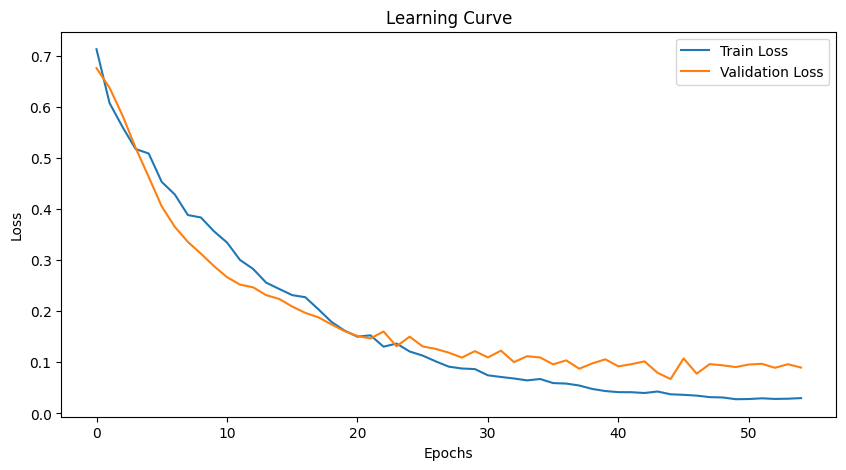

Test Loss: 0.084, Test Accuracy: 0.996

Matthews Correlation Coefficient: 0.989

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        91
         1.0       0.99      1.00      0.99        91

    accuracy                           0.99       182
   macro avg       0.99      0.99      0.99       182
weighted avg       0.99      0.99      0.99       182


Confusion Matrix:


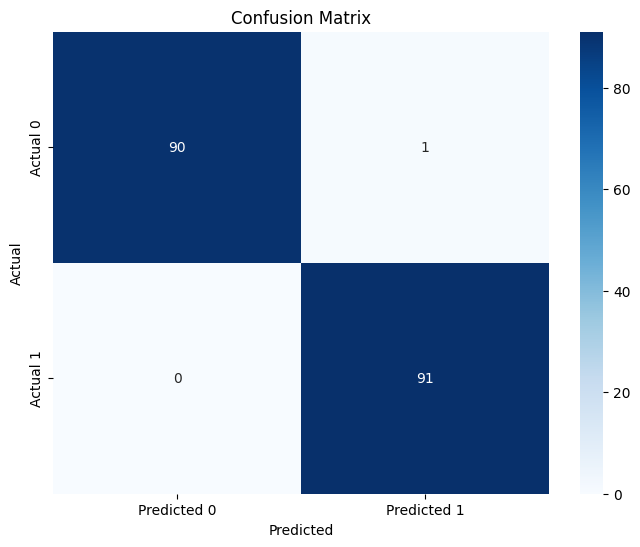

In [16]:
device, model, criterion, optimizer = declare_model(model_llm='mT5', kernel_size=KERNEL_SIZE, learning_rate=LEARNING_RATE)
training(train_loader, val_loader, model, criterion, optimizer, device, epochs=EPOCH, patience=PATIENCE, min_delta=MIN_DELTA)
evaluate(test_loader, model, criterion, optimizer, device)